In [23]:
from locale import normalize

import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import pywt
import tensorflow as tf
from skimage.color import rgb2gray

from keras import applications
from skimage.color import rgb2gray

import numpy as np

from sklearn.model_selection import train_test_split
from keras import layers
from keras import models
from keras import utils

import os
import sys
image_folder = '/Volumes/Data/Docs/hand_crop/'

sys.setrecursionlimit(150000)

In [2]:
def w2d(img, mode='haar', level=1):
    image_data = img
    
    #Datatype conversions
    image_data = cv2.cvtColor( image_data,cv2.COLOR_RGB2GRAY )
    #convert to float
    image_data =  np.float32(image_data)
    image_data /= 255;
    # compute coefficients 
    coef=pywt.wavedec2(image_data, mode, level=level)

    #Process Coefficients
    coef_H=list(coef)
    coef_H[0] *= 0;

    # reconstruction
    image_data_H=pywt.waverec2(coef_H, mode);
    image_data_H *= 255;
    image_data_H =  np.uint8(image_data_H)

    return image_data_H

In [3]:
def increase_brightness(img, value=30):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

In [4]:
img = cv2.imread( '/Volumes/Data/Docs/hand_crop/001_1.JPG')
img2 = cv2.imread( '/Volumes/Data/Docs/hand_crop/001_2.JPG')
img3 = cv2.imread( '/Volumes/Data/Docs/hand_crop/001_3.JPG')
img.shape

(250, 250, 3)

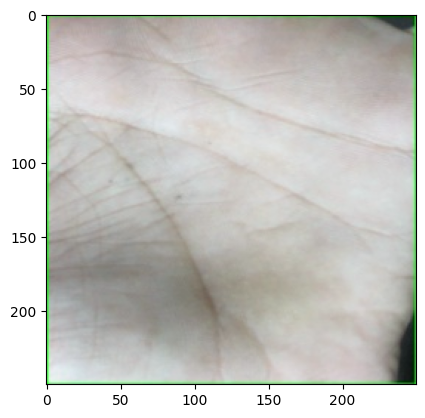

In [5]:
plt.imshow(img)

In [6]:
def get_palm_lines(image):
    rgb_planes = cv2.split(image)
    result_planes = []
    result_norm_planes = []
    for plane in rgb_planes:
        dilated_img = cv2.dilate(plane, np.ones((7,7), np.uint8))
        bg_img = cv2.medianBlur(dilated_img, 21)
        diff_img = 255 - cv2.absdiff(plane, bg_img)
        norm_img = cv2.normalize(diff_img,None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_8UC1)
        norm_img = np.where(norm_img < 255, norm_img // 5, norm_img)
        norm_img[norm_img > 46] = 255

        result_planes.append(diff_img)
        result_norm_planes.append(norm_img)

    result = cv2.merge(result_planes)
    result_norm = cv2.merge(result_norm_planes)
    return result_norm

In [1]:
def center_crop(image, crop_size=224):
    # Get the dimensions of the image
    height, width = image.shape[:2]

    # Calculate the center point
    center_x, center_y = width // 2, height // 2

    # Define the cropping box
    x_start = max(center_x - crop_size // 2, 0)
    y_start = max(center_y - crop_size // 2, 0)
    x_end = x_start + crop_size
    y_end = y_start + crop_size

    # Ensure the crop size does not exceed the image dimensions
    x_end = min(x_end, width)
    y_end = min(y_end, height)

    # Crop the image
    cropped_image = image[y_start:y_end, x_start:x_end]

    # Convert to grayscale if the image is in color
    if len(cropped_image.shape) == 3:
        cropped_image = cv2.cvtColor(cropped_image, cv2.COLOR_BGR2GRAY)
        
    return cropped_image

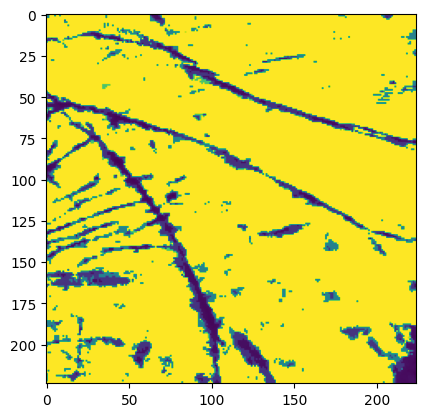

In [8]:
# Assuming result_norm is your processed image
result_norm = get_palm_lines(img)
centered_crop = center_crop(result_norm, 224)

plt.imshow(centered_crop)

In [9]:
def hough_transform_visualization(img, rho_resolution=1, theta_resolution=np.pi/180, threshold=100):
    """
    Perform Hough Transform on an image and visualize the results.

    Parameters:
    - img: Input image (RGB or grayscale)
    - rho_resolution: Distance resolution in pixels of the Hough grid
    - theta_resolution: Angle resolution in radians of the Hough grid
    - threshold: Accumulator threshold parameter for line detection
    
    Returns:
    - lines: Detected lines in the form of rho and theta pairs
    """
    # Convert image to grayscale if it is in RGB
    gray_img = rgb2gray(img) if img.ndim == 3 else img

    # Step 1: Apply edge detection (e.g., Canny) for the Hough transform input
    edges = cv2.Canny((gray_img * 255).astype(np.uint8), 50, 100)

    # Step 2: Perform Hough Transform using OpenCV
    lines = cv2.HoughLines(edges, rho_resolution, theta_resolution, threshold)

    # Create a blank image to accumulate lines
    accumulator = np.zeros_like(edges)
    if lines is not None:
        for line in lines:
            rho, theta = line[0]
            a, b = np.cos(theta), np.sin(theta)
            x0, y0 = a * rho, b * rho
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * a)
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * a)
            cv2.line(accumulator, (x1, y1), (x2, y2), 255, 1)

    # Flatten the accumulator to create a feature vector
    feature_vector = accumulator.flatten()

    return feature_vector, lines
    

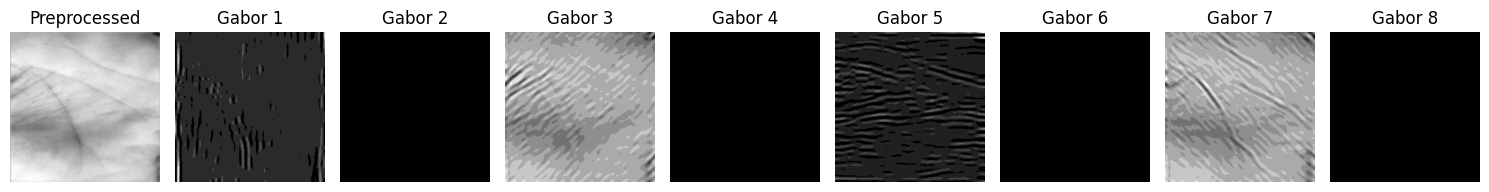

In [10]:
def load_image(image_path):
    """Load an image from the given path."""
    return cv2.imread(image_path)

def preprocess_image(img):
    """Convert to grayscale and apply Gaussian blur."""
    gray_img = rgb2gray(img) if img.ndim == 3 else img
    blurred_img = cv2.GaussianBlur(gray_img, (5, 5), 0)
    return blurred_img

def apply_gabor_filters(img, num_filters=8):
    """Apply Gabor filters to the image."""
    filters = []
    for theta in np.arange(0, np.pi, np.pi / num_filters):
        kernel = cv2.getGaborKernel((21, 21), 8.0, theta, 10.0, 0.5, 0, ktype=cv2.CV_32F)
        filtered_img = cv2.filter2D(img, cv2.CV_8UC3, kernel)
        filters.append(filtered_img)
    return filters

def visualize_images(images, titles):
    """Visualize a list of images with titles."""
    plt.figure(figsize=(15, 5))
    for i in range(len(images)):
        plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i], cmap='gray')
        plt.title(titles[i])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

# Preprocess the image
preprocessed_img = preprocess_image(img3)

# Apply Gabor filters
gabor_images = apply_gabor_filters(preprocessed_img)

# Visualize results
visualize_images([preprocessed_img] + gabor_images, ['Preprocessed'] + [f'Gabor {i+1}' for i in range(len(gabor_images))])

In [11]:

vgg16_base = applications.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in vgg16_base.layers:
    layer.trainable = False

# Function to extract features from palm images
def extract_features(dataset):
    features = vgg16_base.predict(dataset)
    return features


def normalize_palm_image(img):

    # Step 1: Histogram Equalization for contrast enhancement
    img = cv2.equalizeHist(img)

    # Step 2: Apply Gaussian Blur to smooth out noise while retaining edges
    img = cv2.GaussianBlur(img, (5, 5), 0)
#    plt.imshow(img)

    # Step 4: Apply adaptive thresholding to highlight the palm texture
    adaptive_thresh = cv2.adaptiveThreshold(
        img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV, blockSize=15, C=5)

    return adaptive_thresh


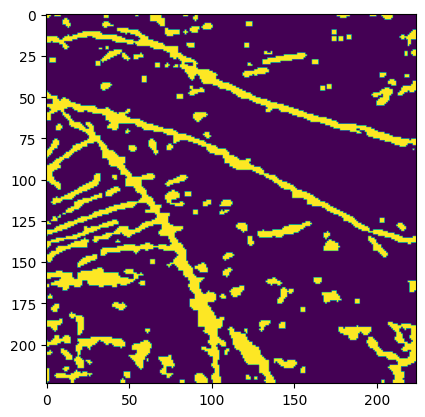

In [12]:
normalized_palm_texture = normalize_palm_image(centered_crop)
normalized_palm_texture2 = hough_transform_visualization(img2)
normalized_palm_texture3 = hough_transform_visualization(img3)

plt.imshow(normalized_palm_texture)

In [13]:
#wavelet_img = increase_brightness(img,50)
#wavelet_img = cv2.addWeighted( img, 1, img, 0, 20)
alpha = 1 # Contrast control (1.0-3.0)
beta = 0 # Brightness control (0-100)

wavelet_img = cv2.convertScaleAbs(img, alpha=alpha, beta=beta)

b = img.copy()
# set green and red channels to 0
b[:, :, 1] = 0
b[:, :, 2] = 0


g = img.copy()
# set blue and red channels to 0
g[:, :, 0] = 0
g[:, :, 2] = 0

r = img.copy()
# set blue and green channels to 0
r[:, :, 0] = 0
r[:, :, 1] = 0



In [14]:
# Path to the folder containing palmprint cropped images
# Blurred image is skipped due full hand undetected by mediapipe
# increasing the quality of data

# images and labels will be loaded into these lists:
# `images` is a list of all images
# `labels` is a list of corresponding labels (person id)
croppeds = []
images = []
labels = []

# Loop through the folder and read each file
for filename in os.listdir(image_folder):
    if filename.endswith(".JPG") or filename.endswith(".bmp"): 
        # Extract the Y value from the first 3 characters of the filename
        data_id = int(filename[:3]) 

        # Full path to the image file
        img_path = os.path.join(image_folder, filename)

        # Read the image using OpenCV
        image = cv2.imread(img_path)  # Grayscale for simplicity (can use color if needed)

        # Use the image wavelet
#        wavelet_img = w2d(image,'db1',5)

        cropped = center_crop(image, 224)
        
        norm_img = get_palm_lines(image)
        crop_img = center_crop(norm_img, 224)

        normalized_img = extract_features(crop_img)
#        wavelet_img = hough_transform_visualization(image) 

        # load the image and label to their respective lists
        croppeds.append(crop_img)

        images.append(normalized_img)
        labels.append(data_id)

# Convert lists to numpy arrays for compatibility with machine learning models
croppeds = np.array(croppeds)
images = np.array(images)
labels = np.array(labels)

# Print shapes to verify loading
print(f"Loaded {len(images)} images with corresponding labels.")
print(f"Image shape: {images.shape}")
print(f"Labels shape: {labels.shape}")

Loaded 1292 images with corresponding labels.
Image shape: (1292, 224, 224)
Labels shape: (1292,)


In [15]:
# Split the data into 80% training and 20% testing sets
X_train, X_test, y_train, y_test = train_test_split(images, labels,
                                                    test_size=0.20, random_state=66)

X_trainx, X_testx, y_trainx, y_testx = train_test_split(croppeds, labels,
                                                    test_size=0.20, random_state=66)

# Verifying the split
print(f'Training set size: {X_train.shape[0]}')
print(f'Test set size: {X_test.shape[0]}')



Training set size: 1033
Test set size: 259


In [16]:
# Train
# Preprocessing: Reshape images and one-hot encode labels
X_train = X_train.reshape(X_train.shape[0], 224, 224, 1)  # (num_samples, height, width, channels)
X_test = X_test.reshape(X_test.shape[0], 224, 224, 1)

# Normalize pixel values to range [0,1]
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

y_train_adjusted = y_train - y_train.min()
y_test_adjusted = y_test - y_test.min()

# Convert labels to categorical (one-hot encoded)
num_classes = len(np.unique(y_train))  # Number of unique user IDs
y_train_encoded = utils.to_categorical(y_train_adjusted, num_classes=num_classes)
y_test_encoded = utils.to_categorical(y_test_adjusted, num_classes=num_classes)


In [17]:
# Train
# Preprocessing: Reshape images and one-hot encode labels
X_trainx = X_trainx.reshape(X_trainx.shape[0], 224, 224, 1)  # (num_samples, height, width, channels)
X_testx = X_testx.reshape(X_testx.shape[0], 224, 224, 1)

# Normalize pixel values to range [0,1]
X_trainx = X_trainx.astype('float32') / 255.0
X_testx = X_testx.astype('float32') / 255.0

y_train_adjustedx = y_trainx - y_trainx.min()
y_test_adjustedx = y_testx - y_testx.min()

# Convert labels to categorical (one-hot encoded)
y_train_encodedx = utils.to_categorical(y_train_adjustedx, num_classes=num_classes)
y_test_encodedx = utils.to_categorical(y_test_adjustedx, num_classes=num_classes)

# Define the CNN model
model = models.Sequential()

# Add Convolutional layers, Pooling layers, and Dropout for regularization
model.add(layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(224, 224, 1)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the feature map into a vector
model.add(layers.Flatten())

# Fully connected layer
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.5))  # Dropout for regularization

# Output layer (Softmax for multi-class classification)
model.add(layers.Dense(num_classes, activation='softmax'))

# Compile the model (using categorical crossentropy for multi-class classification)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train_encoded, epochs=20, batch_size=32, validation_data=(X_test, y_test_encoded))

# Print model summary
model.summary()

In [18]:
#layers.Conv2D alexNet 100 epox

model = models.Sequential([
    layers.Conv2D(filters=256, kernel_size=(11,11), strides=(4,4), activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(3,3)),
    layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    layers.BatchNormalization(),
    layers.MaxPool2D(pool_size=(2,2)),
    layers.Flatten(),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(1024,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes, activation='softmax')
])

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Step 1: Debug the shape of your data
print(f"Shape of X_train before reshaping: {X_train.shape}")
print(f"Expected number of elements after reshaping: {X_train.shape[0]} * 224 * 224")

# Check if the total number of elements match
num_elements = np.prod(X_train.shape)  # Total number of elements in X_train
expected_elements = X_train.shape[0] * 224 * 224  # Expected elements after resizing
print(f"Actual elements: {num_elements}, Expected elements: {expected_elements}")

Shape of X_train before reshaping: (1033, 224, 224, 1)
Expected number of elements after reshaping: 1033 * 224 * 224
Actual elements: 51831808, Expected elements: 51831808


In [20]:
print(f"y_train_encoded shape: {y_train_encoded.shape}")
print(f"y_test_encoded shape: {y_test_encoded.shape}")

y_train_encoded shape: (1033, 230)
y_test_encoded shape: (259, 230)


In [21]:
train_ds=tf.data.Dataset.from_tensor_slices((X_train,y_train_encoded))
test_ds=tf.data.Dataset.from_tensor_slices((X_test,y_test_encoded))

history = model.fit(X_train, y_train_encoded, epochs=100, batch_size=32, validation_data=(X_test, y_test_encoded))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.0116 - loss: 7.4541 - val_accuracy: 0.0039 - val_loss: 5.6818
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0226 - loss: 5.3785 - val_accuracy: 0.0039 - val_loss: 9.6262
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.0390 - loss: 5.0900 - val_accuracy: 0.0039 - val_loss: 18.4891
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.0919 - loss: 4.7005 - val_accuracy: 0.0116 - val_loss: 21.6169
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.1496 - loss: 4.0850 - val_accuracy: 0.0154 - val_loss: 25.3844
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.2570 - loss: 3.5586 - val_accuracy: 0.0000e+00 - val_loss: 36.6949
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.3450 - loss: 2.8235 - val_accuracy: 0.0193 - val_loss: 31.9739
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.3868 - loss: 2.4903 - val_accuracy: 0

In [22]:
train_dsx=tf.data.Dataset.from_tensor_slices((X_trainx,y_train_encodedx))
test_dsx=tf.data.Dataset.from_tensor_slices((X_testx,y_test_encodedx))

#history = model.fit(X_trainx, y_train_encodedx, epochs=100, batch_size=32, validation_data=(X_testx, y_test_encodedx))

Epoch 1/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.0932 - loss: 21.0097 - val_accuracy: 0.0039 - val_loss: 33.5531
Epoch 2/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.2325 - loss: 3.8452 - val_accuracy: 0.0000e+00 - val_loss: 36.5742
Epoch 3/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 37s 1s/step - accuracy: 0.4346 - loss: 2.3961 - val_accuracy: 0.0116 - val_loss: 12.1159
Epoch 4/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.5766 - loss: 1.6908 - val_accuracy: 0.0116 - val_loss: 10.1743
Epoch 5/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.7675 - loss: 0.9300 - val_accuracy: 0.0232 - val_loss: 7.5650
Epoch 6/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8079 - loss: 0.7245 - val_accuracy: 0.1120 - val_loss: 6.5857
Epoch 7/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8935 - loss: 0.4255 - val_accuracy: 0.1853 - val_loss: 5.8552
Epoch 8/100
33/33 ━━━━━━━━━━━━━━━━━━━━ 36s 1s/step - accuracy: 0.8791 - loss: 0.4416 - val_accuracy: 0